Updated: 9 November 2022

In [1]:
from hmcollab import datasets
from hmcollab.directory_tree import HMDatasetDirectoryTree
from hmcollab import directories
from hmcollab import articles
from hmcollab import models
from hmcollab import scoring
from display_data import display_articles

In [5]:
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

## Aim: Explore performance with filtered article dataset
+ It is important to note that I first create the dummies from the full articles dataset, then I remove those articles with transactions below a cutoff point. ArticleKNN uses the full number dummies on a smaller dataset (filtered)
+ kmeans uses the full number of dummies (centroids need to match to ArticleKNN.shape)

## Toy dataset: standard split

In [6]:
tree = HMDatasetDirectoryTree(base=directories.data("toy_orig")) 
toy = datasets.HMDatasetStandard(tree=tree)
print('Transactions shape: ', toy.transactions.shape)
print('Unique customers: ',toy.transactions.customer_id.unique().shape)
print('Train_x:', toy.train_x.shape) 
print('Train_y:', toy.train_y.shape) 
print('Train_vy:', toy.train_vy.shape) 
print('Unique customers train_x: ',toy.train_x.customer_id.unique().shape)
print('Original relevant set from Target class: ',toy.relevant_set.shape)

Transactions shape:  (252406, 5)
Unique customers:  (10899,)
Train_x: (247953, 5)
Train_y: (2035, 5)
Train_vy: (2418, 5)
Unique customers train_x:  (10815,)
Original relevant set from Target class:  (578, 2)


print('Unique customers train_y: ',toy.train_y.customer_id.unique().shape)

### Filter articles

Getting the article IDs

In [7]:
toy_threshold = 50
toy_filtered_article_ids = models.filter_articles(toy.transactions, threshold=toy_threshold)
print('There are {} articles with {} or more transactions'.format(len(toy_filtered_article_ids), toy_threshold))

There are 252 articles with 50 or more transactions


### Create dummies for all articles and then prune it

In [8]:
toy_dummies = articles.ArticleFeaturesSimpleFeatures(toy.articles, use_article_id=True).x
toy_dummies.shape

(105542, 652)

Observe that there are more dummies than samples. This is the input for ArticleKNN

In [9]:
filtered_dummies = toy_dummies[toy_dummies.article_id.isin(
            toy_filtered_article_ids)].drop(columns="article_id")
filtered_dummies.shape

(252, 651)

## Model

Let's find the cutomers at train_x with transactions at train_y

In [10]:
toy_train_x_customer_ids = toy.train_x.customer_id.unique()
toy_trainx_customer_ids_at_y = toy_train_x_customer_ids[np.isin(toy_train_x_customer_ids,toy.train_y.customer_id.unique())]
len(toy_trainx_customer_ids_at_y)

539

In [11]:
# This new model will filter the article dummies for a cutoff number of transactions
toy_knn = models.KnnRecommender(toy, toy_dummies)  # already using only train set

**Recommend for the first customer in the training set**

In [12]:
toy_train_x_customer_ids = toy.train_x.customer_id.unique()
toy.train_x.loc[toy.train_x.customer_id==toy_trainx_customer_ids_at_y[0],:].shape

(205, 5)

In [13]:
# 162 transactions from unique article_ids
toy.train_x.loc[toy.train_x.customer_id==toy_trainx_customer_ids_at_y[0],:].article_id.nunique()

162

In [14]:
# Recommendations for the first customer
toy_recommendations_1st = toy_knn.recommend(toy_trainx_customer_ids_at_y[0])
toy_recommendations_1st

['0469137001',
 '0615141002',
 '0695632002',
 '0716672001',
 '0714790003',
 '0714790020',
 '0573716050',
 '0562245001',
 '0579302001',
 '0723469001',
 '0841434001',
 '0749699002']

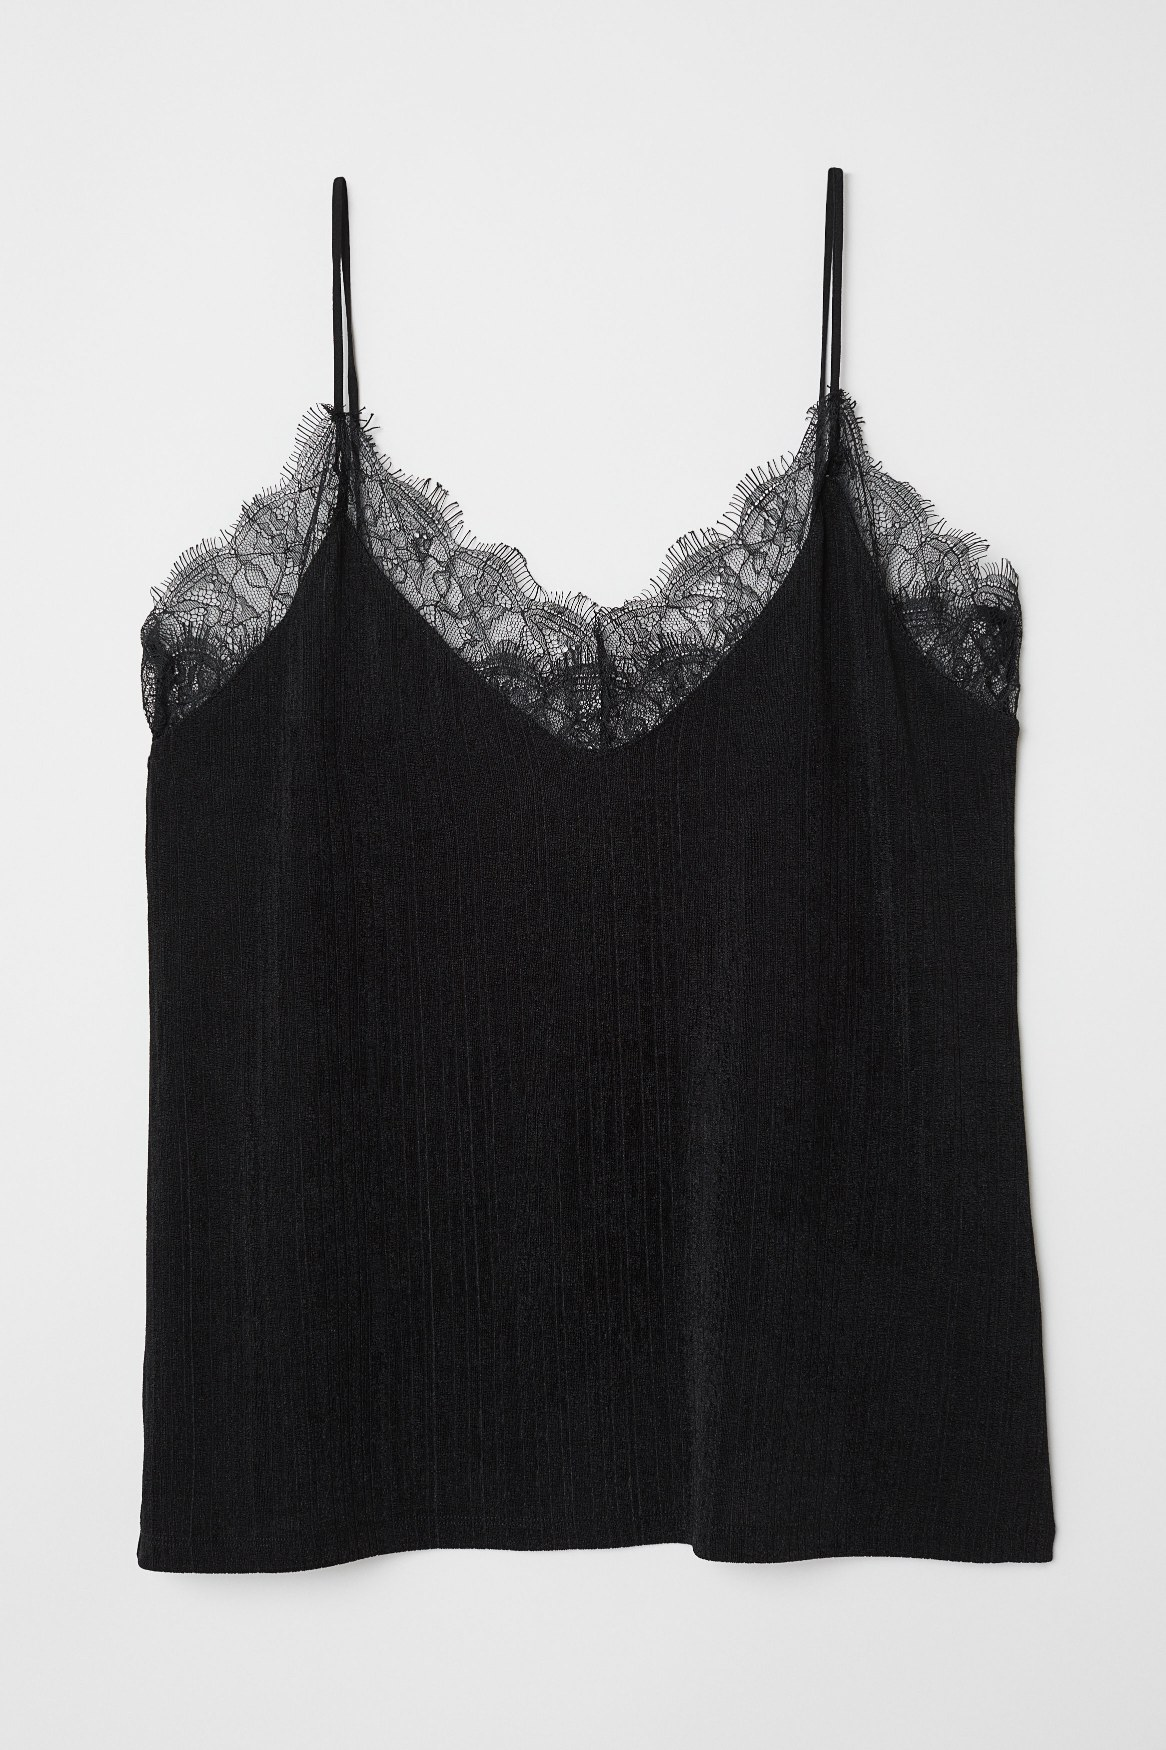

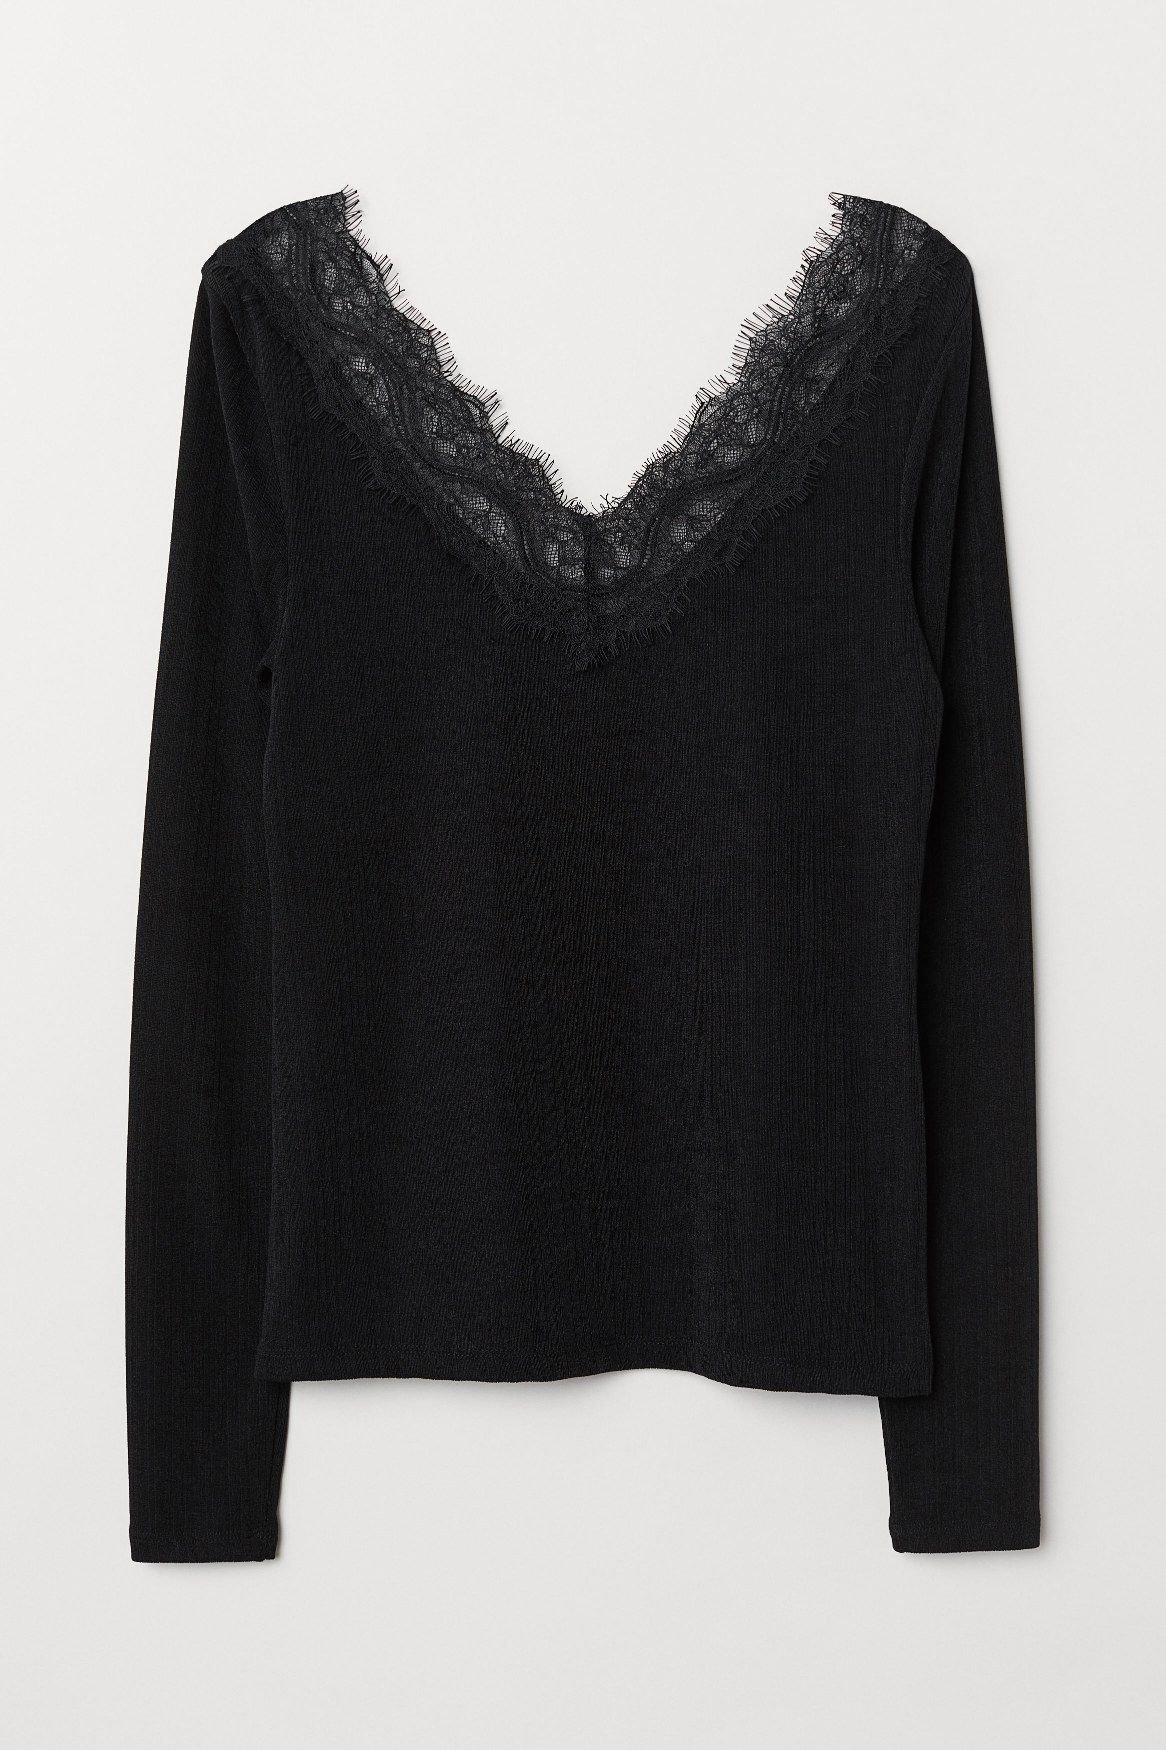

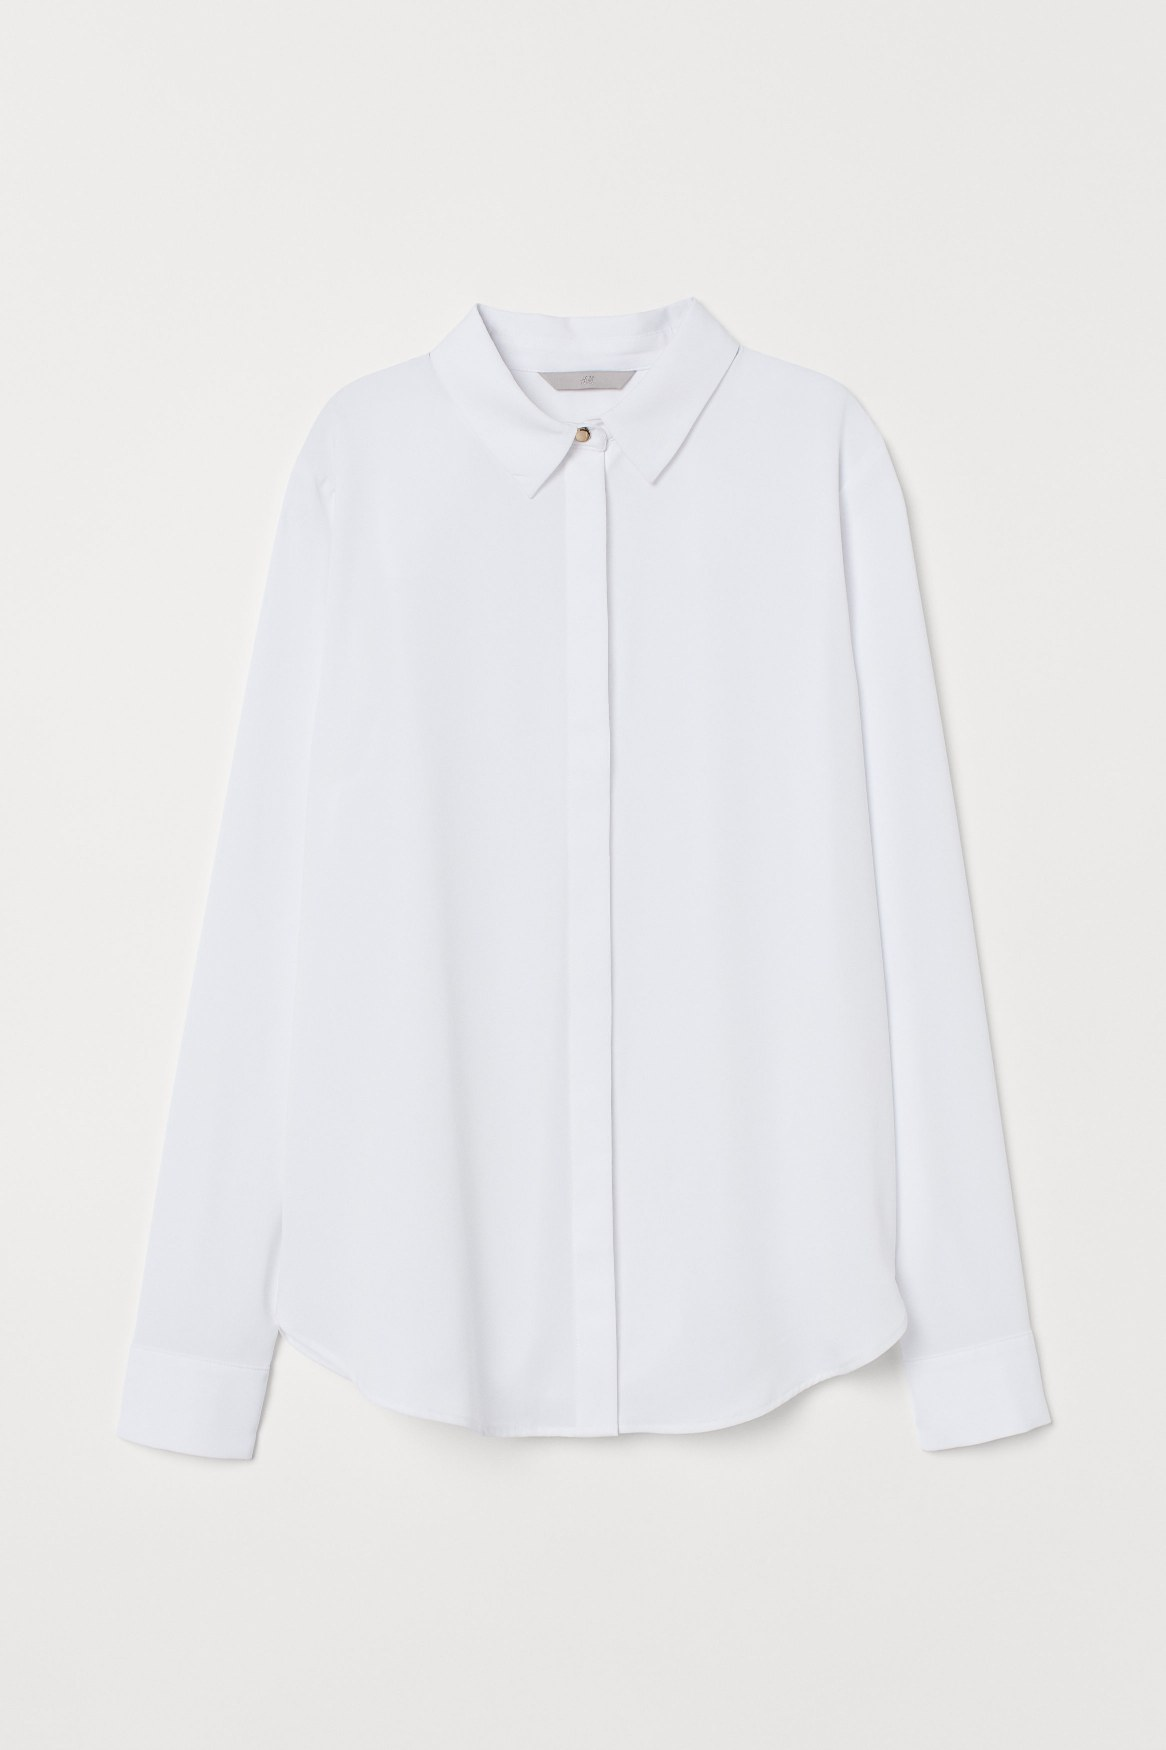

In [15]:
display_articles(toy, toy_recommendations_1st[:3])

## Recommend all in train_x
Train_x has 10815 unique customers, recommend to all is time consuming. We will recommend for the intersection of cutomers with purchases in the last week (train_y) with purchases at train_x (otherwise a cold start)

In [16]:
#539 in both out of 578 at train_y
toy_trainx_c_ids_with_y = toy_train_x_customer_ids[np.isin(toy_train_x_customer_ids,toy.train_y.customer_id.unique())]  


In [17]:
# Before filtering: # 539, 1630 seconds=27mins
# After filtering:  # 539, 113 seconds=1.8 mins
begin = datetime.now()
toy_recommendations_y_customers = toy_knn.recommend_all(toy_trainx_c_ids_with_y)   
print('Seconds: ', (datetime.now() - begin).total_seconds())
toy_recommendations_y_customers.head()

Seconds:  81.475401


,customer_id,prediction
0,0864c58e052b243273d2ab33df294f8e03e9299f84a925...,0469137001 0615141002 0695632002 0716672001 07...
1,0cc82ebae4e0e50bb78179242d10f44e120e3bdb694b91...,0253448003 0579302001 0618800001 0712216001 06...
2,0e7adb227657cb54524f815440a73d5cebf3da3871dbdc...,0562245001 0562245046 0673677002 0795440001 05...
3,516843afa050238837b708073a7bdbbe80a0b04bb19d0c...,0624486001 0711053003 0570002002 0570003002 06...
4,6181c70b68214caf8ff44baa2d309d44ddc24c6e1f42da...,0399256018 0562245004 0554598003 0610776001 06...


In [16]:
# Saving the file locally (Gina)
# toy_recommendations_y_customers.to_csv('../gina/toy_y_relevant_539_artsfiltered.csv')

In [17]:
# Note: this implementations takes about the same that the original in the package
# def recommend_all_new(knn, customer_list, drop_duplicates=True):   # 284 seconds for 100 customers, #289 without df
#     all_customers = []
#     for c in customer_list:
#         recommendations = knn.recommend(c, drop_duplicates=drop_duplicates)
#         all_customers.append([c, " ".join(recommendations)])
#     df = pd.DataFrame(all_customers, columns=["customer_id","prediction"])
#     return df

## Scores for toy dataset

In [18]:
# After filtering map_at_k improved from 0 to 0.000846 
rel_y = datasets.target_to_relevant(toy.train_y)
t = scoring.relevant(toy_recommendations_y_customers, rel_y)
print('t has {} records \n'.format(t.shape[0]))

# print("precision_at_k:")
# for i in range(len(t[0])):
#     print(scoring.precision_at_k(t[0][: i + 1]))

print("ap_at_k:")
print(t.apply(scoring.ap_at_k),'\n')

print("map_at_k:", scoring.map_at_k(t))

t has 539 records 

ap_at_k:
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
534    0.0
535    0.0
536    0.0
537    0.0
538    0.0
Length: 539, dtype: float64 

map_at_k: 0.0008467259394903179


## Full dataset: standard split

In [19]:
# 'Standard' uses all customers for training and creates validation and test set with the last 2 weeks
begin = datetime.now()
tree = HMDatasetDirectoryTree(base=directories.data()) 
full = datasets.HMDatasetStandard(tree=tree)
print('Seconds: ',(datetime.now() - begin).total_seconds())

print('Transactions shape: ', full.transactions.shape)
print('Unique customers: ',full.transactions.customer_id.unique().shape)
print('Train_x:', full.train_x.shape) 
print('Train_y:', full.train_y.shape) 
print('Train_vy:', full.train_vy.shape) 
print('Unique customers train_x: ',full.train_x.customer_id.unique().shape)
print('Original relevant set from Target class: ',full.relevant_set.shape)

Transactions shape:  (31788324, 5)
Unique customers:  (1362281,)
Train_x: (31218444, 5)
Train_y: (266364, 5)
Train_vy: (303516, 5)
Unique customers train_x:  (1349610,)
Original relevant set from Target class:  (75481, 2)


### Create dummies for all articles and then prune it
Note that, since articles doesn't change if we use toy or full, the shape for full_dummies is the same as toy_dummies

In [20]:
begin = datetime.now()
full_dummies = articles.ArticleFeaturesSimpleFeatures(full.articles, use_article_id=True).x
print('Seconds: ',(datetime.now() - begin).total_seconds())
full_dummies.shape

Seconds:  0.389593


(105542, 652)

## Model

Let's find the cutomers at train_x with transactions at train_y. Note: Using sets is faster

In [21]:
begin = datetime.now()
full_train_x_customer_ids_set = set(full.train_x.customer_id)  # no need for unique()
print('Seconds: ',(datetime.now() - begin).total_seconds())

len(full_train_x_customer_ids_set)

Seconds:  4.558355


1349610

In [22]:
begin = datetime.now()
full_trainx_customer_ids_at_y = full_train_x_customer_ids_set.intersection(set(full.train_y.customer_id))
print('Seconds: ',(datetime.now() - begin).total_seconds())

len(full_trainx_customer_ids_at_y)

Seconds:  0.047079


68877

It might take about 4-5 hours to run 68,877 customers

In [23]:
begin = datetime.now()

# This new model will filter the article dummies for a cutoff number of transactions
full_knn = models.KnnRecommender(full, full_dummies, threshold=300)  # already using only train set

print('Seconds: ',(datetime.now() - begin).total_seconds())

Seconds:  3.136388


**Recommend for the first customer in the training set**

In [24]:
one_customer_id = next(iter(full_train_x_customer_ids_set))
one_customer_id

'f59e9d742705c0798535f0a69dbdbd9b1f330e24aabf251c1c21cd3c38aa90fa'

In [25]:
full.train_x.loc[full.train_x.customer_id==one_customer_id,:].shape

(8, 5)

In [26]:
# 3 transactions from unique article_ids
full.train_x.loc[full.train_x.customer_id==one_customer_id,:].article_id.nunique()


6

In [27]:
# Recommendations for the first customer
full_recommendations_1st = full_knn.recommend(one_customer_id)
full_recommendations_1st

['0458543005',
 '0559630020',
 '0493438027',
 '0567993016',
 '0522346004',
 '0610744007',
 '0670691001',
 '0670752002',
 '0564358046',
 '0587026014',
 '0448509001',
 '0448509017']